# Utilisation des CNNs avec Keras sur des données d'expression faciale

## Vérification de l'utilisation de GPU

Allez dans le menu `Exécution > Modifier le type d'execution` et vérifiez que l'on est bien en Python 3 et que l'accélérateur matériel est configuré sur « GPU ».

In [9]:
!nvidia-smi

Mon Feb 26 12:32:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.33                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   46C    P0              22W /  80W |   1416MiB /  6144MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Téléchargement du dataset d'expressions faciales depuis un repo git

**Setup**

In [2]:
!git clone https://github.com/muxspace/facial_expressions.git
!dir
!head facial_expressions/data/legend.csv

Cloning into 'facial_expressions'...
Updating files:  10% (1455/13996)
Updating files:  11% (1540/13996)
Updating files:  12% (1680/13996)
Updating files:  13% (1820/13996)
Updating files:  14% (1960/13996)
Updating files:  15% (2100/13996)
Updating files:  16% (2240/13996)
Updating files:  17% (2380/13996)
Updating files:  18% (2520/13996)
Updating files:  19% (2660/13996)
Updating files:  20% (2800/13996)
Updating files:  21% (2940/13996)
Updating files:  21% (3009/13996)
Updating files:  22% (3080/13996)
Updating files:  23% (3220/13996)
Updating files:  24% (3360/13996)
Updating files:  25% (3499/13996)
Updating files:  26% (3639/13996)
Updating files:  27% (3779/13996)
Updating files:  27% (3880/13996)
Updating files:  27% (3905/13996)
Updating files:  28% (3919/13996)
Updating files:  28% (3938/13996)
Updating files:  28% (3964/13996)
Updating files:  29% (4059/13996)
Updating files:  30% (4199/13996)
Updating files:  31% (4339/13996)
Updating files:  32% (4479/13996)
Updating fi

## Import de TensorFlow et des autres librairies nécessaires

In [4]:
import itertools
import pathlib
import typing

import cv2
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import sklearn.metrics
import sklearn.model_selection
import sklearn.utils
from tensorflow import keras

## Chargement des données

*Après une rapide étude du dataset à l'aide de commandes usuelles du terminal, implémentez les fonctions de chargement du dataset. Vous pourrez utiliser [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) pour charger un CSV dans une [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).*

In [ ]:
!pwd
!ls

In [ ]:
!cd facial_expressions && ls
!cd facial_expressions/data && ls
!cd facial_expressions/data && head legend.csv

In [ ]:
!cd facial_expressions/data && head 500_picts_satz.csv

In [10]:
# Votre code ici
def load_data(csv_path: pathlib.Path, shuffle: bool = True
             ) -> typing.Tuple[np.ndarray, np.ndarray]:
  data = pd.read_csv(csv_path)
  return data["image"], data["emotion"]


images, labels = load_data(
    pathlib.Path("facial_expressions") / "data" / "legend.csv")

In [11]:
labels

0            anger
1         surprise
2          disgust
3             fear
4          neutral
           ...    
13685    HAPPINESS
13686    HAPPINESS
13687    HAPPINESS
13688    HAPPINESS
13689    HAPPINESS
Name: emotion, Length: 13690, dtype: object

## Exploration du dataset

*Affichez les caractéristiques du dataset suivantes :*

- *La taille des données*
- *Le nombre d'exemple dans chaque classe*
- *Quelques exemples annotés*

In [12]:
def get_image(name):
  return f'facial_expressions/images/{name}'

taille des données 13690
nombre d'exemples dans chaque classe
emotion
neutral      6717
happiness    5309
HAPPINESS     387
surprise      356
anger         228
DISGUST       195
NEUTRAL       151
SADNESS       144
sadness       124
ANGER          24
disgust        13
fear           13
SURPRISE       12
contempt        9
FEAR            8
Name: count, dtype: int64


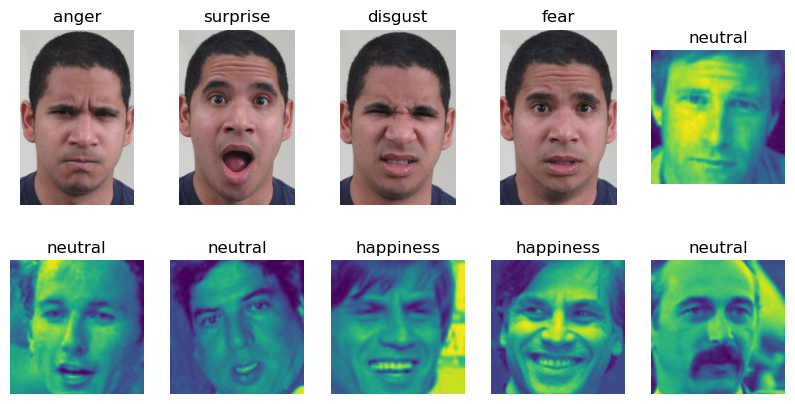

In [13]:
# Votre code ici
print(f"taille des données { len(images)}")
print(f"nombre d'exemples dans chaque classe\n{labels.value_counts()}")

# displaying examples
n = 10
fig,axs = plt.subplots(2,int(n/2),figsize=(10,5))
for i in range(2):
  for j in range(int(n/2)):
    image = plt.imread(get_image(images[i*n+j]))
    axs[i,j].imshow(image)
    axs[i,j].set_title(labels[i*n+j])
    axs[i,j].axis("off")


In [14]:
labels.unique()

array(['anger', 'surprise', 'disgust', 'fear', 'neutral', 'happiness',
       'sadness', 'contempt', 'NEUTRAL', 'SADNESS', 'DISGUST', 'FEAR',
       'SURPRISE', 'ANGER', 'HAPPINESS'], dtype=object)

In [15]:
labels=labels.apply(lambda x : str.upper(x))

In [16]:
labels.unique()

array(['ANGER', 'SURPRISE', 'DISGUST', 'FEAR', 'NEUTRAL', 'HAPPINESS',
       'SADNESS', 'CONTEMPT'], dtype=object)

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

In [19]:
type(label_encoder.transform(['HAPPINESS',"ANGER"]))

numpy.ndarray

In [20]:
print(images.info())
print(labels.info())

<class 'pandas.core.series.Series'>
RangeIndex: 13690 entries, 0 to 13689
Series name: image
Non-Null Count  Dtype 
--------------  ----- 
13690 non-null  object
dtypes: object(1)
memory usage: 107.1+ KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 13690 entries, 0 to 13689
Series name: emotion
Non-Null Count  Dtype 
--------------  ----- 
13690 non-null  object
dtypes: object(1)
memory usage: 107.1+ KB
None


### Solution

## Séparation train/test

Pour pouvoir évaluer notre modèle, il faut mettre de côté une partie des données. On ne les utilisera pas pendant l'apprentissage.

In [21]:
# Séparation en train et test (la séparation en train/valid est faite
# automatiquement dans model.fit())
# On fera une séparation 80/20 en respectant les proportions des classes
train_images, test_images, train_labels, test_labels = (
    sklearn.model_selection.train_test_split(images,
                                             labels,
                                             test_size=0.2,
                                             stratify=labels))

## Apprentisage

- *Définissez un modèle*
- *Entraînez votre modèle avec `model.fit(…)`*
- *Affichez vos courbes d'apprentissage*

In [22]:
img0 = plt.imread(get_image(images[0]))
img0.shape

(536, 347, 3)

In [23]:
def resize_image(image_path, target_size):
    """
    Resize the image to the target size.

    Parameters:
        image_path (str): Path to the input image file.
        target_size (tuple): Desired output size in the format (width, height).

    Returns:
        numpy.ndarray: Resized image array.
    """
    # Read the image
    image = cv2.imread(image_path)

    # Resize the image
    resized_image = cv2.resize(image, (target_size[0],target_size[1]), interpolation=cv2.INTER_AREA)

    return resized_image

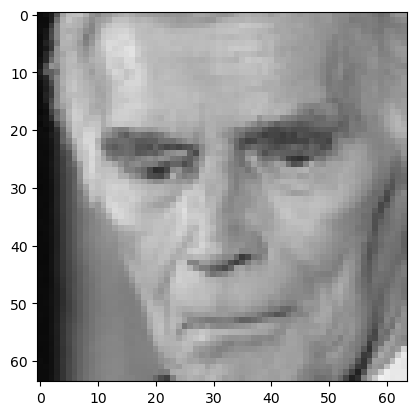

In [26]:
input_size = (64,64,3)
plt.imshow(resize_image(get_image(images[1876]),input_size))

In [25]:
len(labels.unique())

8

In [87]:
# Votre code ici
def init_model():
    model = keras.models.Sequential()
    number_of_labels = len(labels.unique())
    # Add layers to the model
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(input_size[0],input_size[1],1)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))

    # Flatten the output of the convolutional layers
    model.add(keras.layers.Flatten())

    # Add Dense layers for classification
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(number_of_labels, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

# Display model summary
model = init_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 flatten_2 (Flatten)         (None, 53824)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                1722400   
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                      

In [28]:
def read_and_convert_to_gray(image_name):
    """
    Read images from a list of file paths and convert them to grayscale.

    Parameters:
        image_paths (list): List of file paths to the input images.

    Returns:
        list: List of grayscale images (numpy.ndarray).
    """
    grayscale_images = []
    for img_name in image_name:
        # Read the image
        image = resize_image(get_image(img_name),input_size)

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Append the grayscale image to the list
        grayscale_images.append(gray_image,)

    return np.array(grayscale_images)

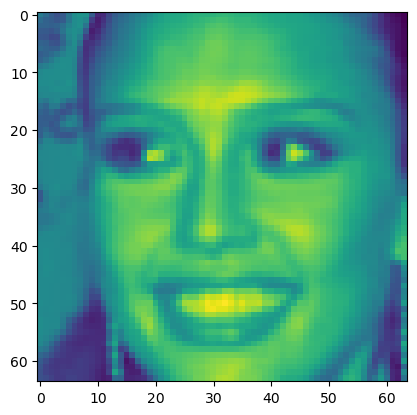

In [30]:
plt.imshow(read_and_convert_to_gray(train_images[:10])[0])

In [32]:
train_images_gray=read_and_convert_to_gray(train_images)


In [40]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12755565970087826756
xla_global_id: -1
]


In [81]:
model.fit(train_images_gray,label_encoder.transform(train_labels),verbose=True,epochs=5,batch_size=32)

Epoch 1/5
343/343 [==============================] - 22s 61ms/step - loss: 3.4581 - accuracy: 0.6734
Epoch 2/5
343/343 [==============================] - 20s 59ms/step - loss: 0.7060 - accuracy: 0.7564
Epoch 3/5
343/343 [==============================] - 20s 58ms/step - loss: 0.6518 - accuracy: 0.7722
Epoch 4/5
343/343 [==============================] - 20s 58ms/step - loss: 0.5836 - accuracy: 0.7960
Epoch 5/5
343/343 [==============================] - 20s 59ms/step - loss: 0.5323 - accuracy: 0.8104


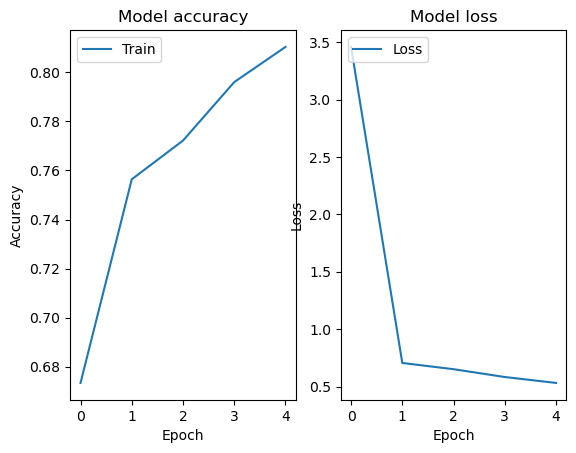

In [82]:
fig,axs = plt.subplots(1,2)

history = model.history

axs[0].plot(history.history['accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train'], loc='upper left')
# loss
axs[1].plot(history.history['loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Loss'], loc='upper left')
plt.show()

## Évaluation des performances en test

*Utilisez `model.evaluate(…)` pour mesurer les performances de votre modèle sur l'ensemble de test.*

In [83]:
test_images_gray = read_and_convert_to_gray(test_images)
model.evaluate(test_images_gray,label_encoder.transform(test_labels))

86/86 [==============================] - 1s 12ms/step - loss: 0.7885 - accuracy: 0.7637


[0.7885121703147888, 0.7636961340904236]

86/86 [==============================] - 1s 13ms/step


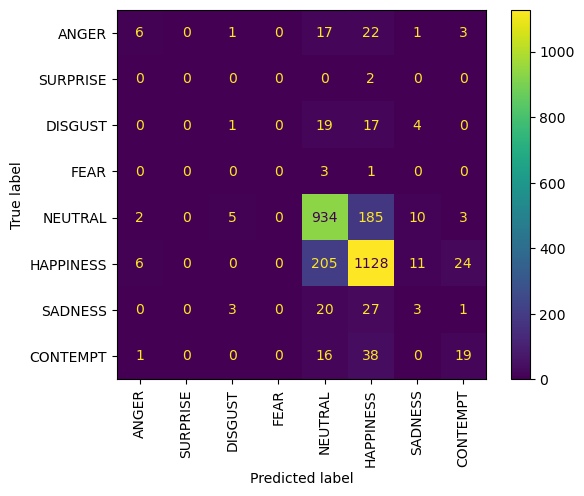

In [84]:
predicted_labels = model.predict(test_images_gray)
predicted_labels=label_encoder.inverse_transform(predicted_labels.argmax(axis=1))
conf_matr1 = sklearn.metrics.confusion_matrix(test_labels,predicted_labels)
sklearn.metrics.ConfusionMatrixDisplay(conf_matr1,display_labels=labels.unique()).plot(xticks_rotation='vertical')

## Avec des pondération pour les classes

Il est possible de donner un argument `class_weight` à `model.fit`. Cet argument correspond à un facteur multiplicatif dans la loss à appliquer au score de chaque classe.

*Utilisez [`sklearn.utils.class_weight.compute_class_weight`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) pour calculer les poids à attribuer à chaque classe.*

In [85]:
class_weights = sklearn.utils.class_weight.compute_class_weight(
    class_weight="balanced",classes=  np.unique(train_labels),y= train_labels)
print(class_weights)

[  6.77722772 195.57142857   8.19760479  80.52941176   0.30041694
   0.24918092   6.39719626   4.65646259]


## Clipping des pondérations

Dans un premier temps, il peut être intéressant de vérifier que les poids de classe améliorent les performances du modèle pour les classes sous-représentées sans utiliser toutefois des pondérations trop fortes.

*Utilisez [`numpy.clip`](https://numpy.org/doc/stable/reference/generated/numpy.clip.html) pour restreindre les valeurs des pondérations à $[0, 5]$.*

In [86]:
# Votre code ici
clipped_weights=np.clip(class_weights, 0, 5)
clipped_weights

array([5.        , 5.        , 5.        , 5.        , 0.30041694,
       0.24918092, 5.        , 4.65646259])

In [88]:
model_weighted = init_model()
model_weighted.fit(train_images_gray,label_encoder.transform(train_labels),verbose=True,epochs=5,batch_size=32,class_weight=dict(enumerate(clipped_weights)))

Epoch 1/5
343/343 [==============================] - 22s 63ms/step - loss: 3.7679 - accuracy: 0.3449
Epoch 2/5
343/343 [==============================] - 21s 60ms/step - loss: 0.9925 - accuracy: 0.4640
Epoch 3/5
343/343 [==============================] - 21s 60ms/step - loss: 0.7533 - accuracy: 0.5583
Epoch 4/5
343/343 [==============================] - 21s 61ms/step - loss: 0.5739 - accuracy: 0.6224
Epoch 5/5
343/343 [==============================] - 21s 61ms/step - loss: 0.4473 - accuracy: 0.6712


In [72]:
def evaluate(model,test_images,test_labels):
  test_images_gray = read_and_convert_to_gray(test_images)
  test_loss, test_acc = model.evaluate(test_images_gray, label_encoder.transform(test_labels), verbose=2)
  print(f"Test accuracy: {test_acc}")
  print(f"Test loss: {test_loss}")

In [95]:
evaluate(model_weighted,test_images,test_labels)

86/86 - 1s - loss: 1.2423 - accuracy: 0.5606 - 1s/epoch - 14ms/step
Test accuracy: 0.5606281757354736
Test loss: 1.2423256635665894


86/86 [==============================] - 1s 12ms/step


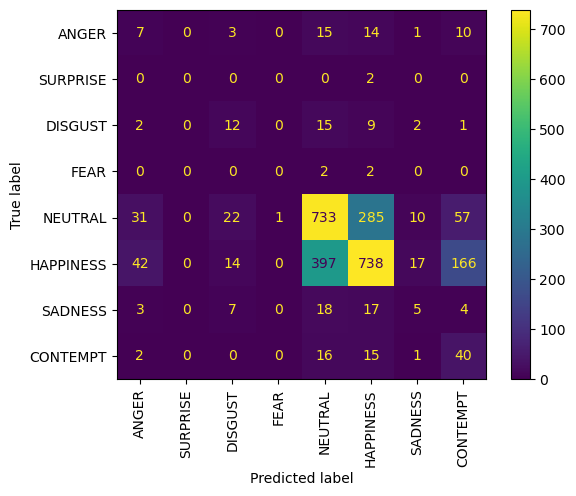

In [93]:
predicted_labels = model_weighted.predict(test_images_gray)
predicted_labels=label_encoder.inverse_transform(predicted_labels.argmax(axis=1))
conf_matr2 = sklearn.metrics.confusion_matrix(test_labels,predicted_labels)
sklearn.metrics.ConfusionMatrixDisplay(conf_matr2,display_labels=labels.unique()).plot(xticks_rotation='vertical')

### Solution

## Utilisation des pondérations

*Re-contruisez votre modèle et entraînez le avec les pondérations calculées, puis évaluez-le.*

In [91]:
model_weighted2 = init_model()
model_weighted2.fit(train_images_gray,label_encoder.transform(train_labels),verbose=True,epochs=5,batch_size=32,class_weight=dict(enumerate(class_weights)))

Epoch 1/5
343/343 [==============================] - 23s 65ms/step - loss: 4.3378 - accuracy: 0.2065
Epoch 2/5
343/343 [==============================] - 22s 63ms/step - loss: 2.0523 - accuracy: 0.1629
Epoch 3/5
343/343 [==============================] - 21s 62ms/step - loss: 1.9933 - accuracy: 0.1689
Epoch 4/5
343/343 [==============================] - 20s 59ms/step - loss: 1.9575 - accuracy: 0.1663
Epoch 5/5
343/343 [==============================] - 20s 59ms/step - loss: 1.9949 - accuracy: 0.1672


In [94]:
evaluate(model_weighted2,test_images,test_labels)

86/86 - 1s - loss: 2.0828 - accuracy: 0.0847 - 1s/epoch - 13ms/step
Test accuracy: 0.08473338186740875
Test loss: 2.082761287689209


86/86 [==============================] - 1s 13ms/step


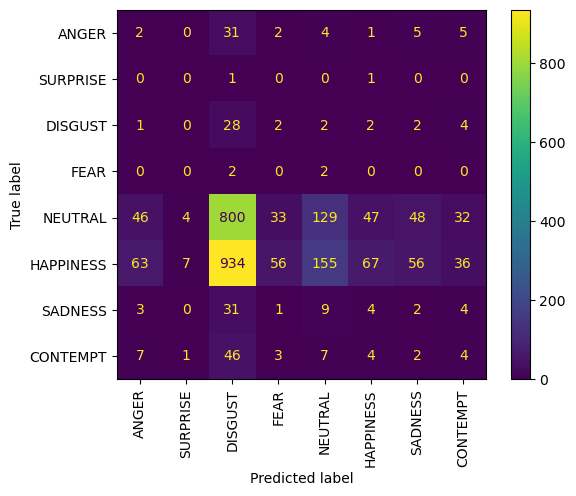

In [96]:
predicted_labels = model_weighted2.predict(test_images_gray)
predicted_labels=label_encoder.inverse_transform(predicted_labels.argmax(axis=1))
conf_matr3 = sklearn.metrics.confusion_matrix(test_labels,predicted_labels)
sklearn.metrics.ConfusionMatrixDisplay(conf_matr3,display_labels=labels.unique()).plot(xticks_rotation='vertical')